# Fit model to data
We will fit a `Polyclonal` model to the RBD antibody mix we simulated.

First, we read in that simulated data.
Recall that we simulated both "exact" and "noisy" data, with several average per-library mutations rates, and at six different concentrations.
Here we analyze the noisy data for the library with an average of 2 mutations per gene, measured at three different concentrations, as this represents a fairly realistic representation of a real experiment:

In [1]:
import pandas as pd

import polyclonal

noisy_data = (
    pd.read_csv("RBD_variants_escape_noisy.csv", na_filter=None)
    .query('library == "avg2muts"')
    .query("concentration in [0.25, 1, 4]")
    .reset_index(drop=True)
)

noisy_data

,library,aa_substitutions,concentration,prob_escape,IC90
0,avg2muts,,0.25,0.050440,0.1128
1,avg2muts,,0.25,0.143100,0.1128
2,avg2muts,,0.25,0.054520,0.1128
3,avg2muts,,0.25,0.084730,0.1128
4,avg2muts,,0.25,0.041740,0.1128
...,...,...,...,...,...
89995,avg2muts,Y396T Y473L,4.00,0.000000,0.5832
89996,avg2muts,Y421W S359K,4.00,0.044600,0.5777
89997,avg2muts,Y449L V503T L335M,4.00,0.000000,1.0520
89998,avg2muts,Y473E L518F D427L,4.00,0.002918,1.1600


Initialize a `Polyclonal` model with these data, including three epitopes.
We know from [prior work](https://www.nature.com/articles/s41467-021-24435-8) the three most important epitopes and a key mutation in each, so we use this prior knowledge to "seed" initial guesses that assign large escape values to a key site in each epitope:

 - site 417 for class 1 epitope, which is often the least important
 - site 484 for class 2 epitope, which is often the dominant one
 - site 444 for class 3 epitope, which is often the second most dominant one

In [2]:
poly_abs = polyclonal.Polyclonal(
    data_to_fit=noisy_data,
    activity_wt_df=pd.DataFrame.from_records(
        [
            ("1", 1.0),
            ("2", 3.0),
            ("3", 2.0),
        ],
        columns=["epitope", "activity"],
    ),
    site_escape_df=pd.DataFrame.from_records(
        [
            ("1", 417, 10.0),
            ("2", 484, 10.0),
            ("3", 444, 10.0),
        ],
        columns=["epitope", "site", "escape"],
    ),
    data_mut_escape_overlap="fill_to_data",
)

Now fit the `Polyclonal` model using the default optimization settings and logging output every 100 steps.
Note how the fitting first just fits a site level model to estimate the average effects of mutations at each site, and then fits the full model:

In [3]:
# NBVAL_IGNORE_OUTPUT
opt_res = poly_abs.fit(logfreq=100)

# First fitting site-level model.
# Starting optimization of 522 parameters at Fri Mar 11 15:04:46 2022.
       step   time_sec       loss   fit_loss reg_escape  regspread
          0   0.057235     9144.4     9144.2    0.29701          0
        100     5.4216     1337.3     1333.8     3.5301          0
        200     10.753     1313.1     1308.9     4.2383          0
        300     15.942     1304.6     1299.4     5.1306          0
        400     21.156     1301.3     1295.4     5.8542          0
        500     26.371     1297.7     1291.5     6.1713          0
        600     31.357     1297.2     1290.9     6.3274          0
        700     36.331     1296.5     1289.8     6.6536          0
        800     41.361       1296     1289.2     6.8122          0
        900     46.361     1295.7     1288.8     6.8608          0
       1000     51.606     1295.4     1288.5     6.9429          0
       1100     56.692       1295       1288     6.9748          0
       1200     61.545  

We can now visualize the resulting fits for the activities and escape values, and they can be compared back to the earlier "true" results used to simulate the data:

In [4]:
# NBVAL_IGNORE_OUTPUT
poly_abs.activity_wt_barplot()

alt.Chart(...)

In [5]:
# NBVAL_IGNORE_OUTPUT
poly_abs.mut_escape_lineplot()

alt.VConcatChart(...)

In [6]:
# NBVAL_IGNORE_OUTPUT
poly_abs.mut_escape_heatmap()

alt.VConcatChart(...)

For these simulated data, we can also see how well the fit model does on the "true" simulated values from a library with a different (higher) mutation rate.
We therefore read in the "exact" simulated data from a library with a different mutation rate:

In [7]:
exact_data = (
    pd.read_csv("RBD_variants_escape_exact.csv", na_filter=None)
    .query('library == "avg3muts"')
    .query("concentration in [0.25, 1, 0.5]")
    .reset_index(drop=True)
)

First, we will compare the true simulated IC90 values to those predicted by the fit model.
We make the comparison on a log scale, and clip IC90s at values >50 as likely to be way outside the dynamic range given the concentrations used:

Correlation (R^2) is 0.98


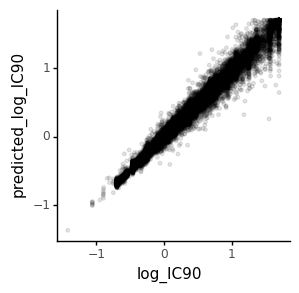

In [8]:
import numpy

from plotnine import *

max_ic90 = 50

# we only need the variants, not the concentration for the IC90 comparison
ic90s = (
    exact_data[["aa_substitutions", "IC90"]]
    .assign(IC90=lambda x: x["IC90"].clip(upper=max_ic90))
    .drop_duplicates()
)

ic90s = poly_abs.icXX(ic90s, x=0.9, col="predicted_IC90", max_c=max_ic90)

ic90s = ic90s.assign(
    log_IC90=lambda x: numpy.log10(x["IC90"]),
    predicted_log_IC90=lambda x: numpy.log10(x["predicted_IC90"]),
)

corr = ic90s["log_IC90"].corr(ic90s["predicted_log_IC90"]) ** 2
print(f"Correlation (R^2) is {corr:.2f}")

ic90_corr_plot = (
    ggplot(ic90s)
    + aes("log_IC90", "predicted_log_IC90")
    + geom_point(alpha=0.1, size=1)
    + theme_classic()
    + theme(figure_size=(3, 3))
)

_ = ic90_corr_plot.draw()

Next we see how well the model predicts the variant-level escape probabilities $p_v\left(c\right)$, by reading in exact data from the simulations, and then making predictions of escape probabilities.
We both examine and plot the correlations:

Correlations (R^2) at each concentration:


,concentration,correlation (R^2)
0,0.25,0.99
1,0.50,0.99
2,1.00,0.98


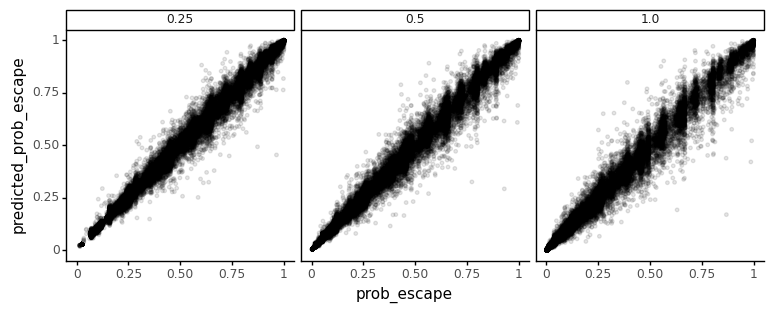

In [9]:
# NBVAL_IGNORE_OUTPUT

exact_vs_pred = poly_abs.prob_escape(variants_df=exact_data)

print(f"Correlations (R^2) at each concentration:")
display(
    exact_vs_pred.groupby("concentration")
    .apply(lambda x: x["prob_escape"].corr(x["predicted_prob_escape"]) ** 2)
    .rename("correlation (R^2)")
    .reset_index()
    .round(2)
)

pv_corr_plot = (
    ggplot(exact_vs_pred)
    + aes("prob_escape", "predicted_prob_escape")
    + geom_point(alpha=0.1, size=1)
    + facet_wrap("~ concentration", nrow=1)
    + theme_classic()
    + theme(figure_size=(3 * exact_vs_pred["concentration"].nunique(), 3))
)

_ = pv_corr_plot.draw()

We also examine the correlation between the "true" and inferred mutation-escape values, $\beta_{m,e}$.
In general, it's necessary to ensure the epitopes match up for this type of comparison as it is arbitrary which epitope in the model is given which name.
But above we seeded the epitopes at the site level using `site_effects_df` when we initialized the `Polyclonal` object, so they match up with class 1, 2, and 3:

In [10]:
# NBVAL_IGNORE_OUTPUT

import altair as alt

mut_escape_pred = pd.read_csv("RBD_mut_escape_df.csv").merge(
    (
        poly_abs.mut_escape_df.assign(
            epitope=lambda x: "class " + x["epitope"].astype(str)
        ).rename(columns={"escape": "predicted escape"})
    ),
    on=["mutation", "epitope"],
    validate="one_to_one",
)

print("Correlation (R^2) between predicted and true values:")
corr = (
    mut_escape_pred.groupby("epitope")
    .apply(lambda x: x["escape"].corr(x["predicted escape"]) ** 2)
    .rename("correlation (R^2)")
    .reset_index()
)
display(corr.round(2))

# for testing since we nbval ignore cell output
assert numpy.allclose(corr["correlation (R^2)"], numpy.array([0.67, 0.91, 0.86]), atol=0.02) == True

corr_chart = (
    alt.Chart(mut_escape_pred)
    .encode(
        x="escape",
        y="predicted escape",
        color="epitope",
        tooltip=["mutation", "epitope"],
    )
    .mark_point(opacity=0.5)
    .properties(width=250, height=250)
    .facet(column="epitope")
    .resolve_scale(
        x="independent",
        y="independent",
    )
)

corr_chart

Correlation (R^2) between predicted and true values:


,epitope,correlation (R^2)
0,class 1,0.67
1,class 2,0.91
2,class 3,0.86


alt.FacetChart(...)

The correlations are strongest for the dominant epitope (class 2), which makes sense as this will drive the highest escape signal.